## SARIMAX_base rivisto con Errori HAC

Data la distribuzione non normale dei residui del SARIMAX_base, e la potenziale presenza di **eteroschedasticità**, si è deciso di rivedere lo script precedente in una versione aggiornata, con la principale aggiunta che ora gli errori standard (e quindi i p-value, i test t, gli intervalli di confidenza per i coefficienti) vengono calcolati utilizzando la **matrice di covarianza di Newey-West**, che è robusta a eteroschedasticità e autocorrelazione (fino a N_LAGS_HAC).

## Vero script

>>> INIZIO SCRIPT: Costruzione Modello Base SARIMAX con Errori Standard Robusti <<<

I risultati di questo script verranno salvati in: '/Users/tommaso/Desktop/tesi-inflation-gt/ARIMAX_modelli/modello_base_hac_v5_corretto'

--- Caricamento Serie Stazionarie da: /Users/tommaso/Desktop/tesi-inflation-gt/First_Difference_indexes/dati_preparati_fase2/indici_gt_nic_stazionari_fase2.csv ---
Serie caricate con successo. Shape: (252, 3)
--- Analisi ACF/PACF per: NIC_destag_ISTAT_diff1 (guida visuale) ---


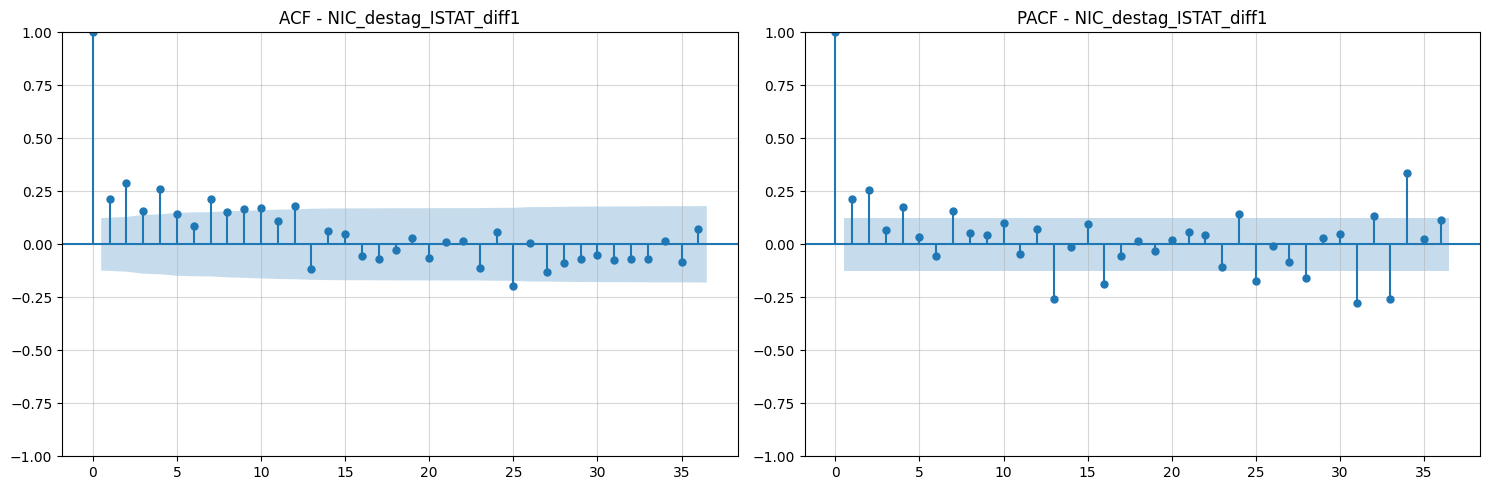


=== INIZIO RICERCA AUTOMATICA ORDINI SARIMA (Criterio: AIC) ===
Range ordini: p<=2, q<=2, P<=1, Q<=1 | d=0, D=0, s=12
Numero totale di combinazioni da testare: 36
Sto testando il modello 1/36: SARIMA(0, 0, 0)(0, 0, 0, 12)...
Sto testando il modello 11/36: SARIMA(0, 0, 2)(1, 0, 0, 12)...
Sto testando il modello 21/36: SARIMA(1, 0, 2)(0, 0, 0, 12)...
Sto testando il modello 31/36: SARIMA(2, 0, 1)(1, 0, 0, 12)...
Sto testando il modello 36/36: SARIMA(2, 0, 2)(1, 0, 1, 12)...

36 modelli sono convergiti con successo su 36 testati.

=== MIGLIOR MODELLO TROVATO (secondo AIC e Ljung-Box) ===
Ordini: SARIMA(1, 0, 1)(0, 0, 0, 12)
AIC: 221.879, BIC: 235.981, LogLik: -106.940
Ljung-Box p-value (residui): 0.184
  -> OK: Residui sembrano non autocorrelati.
=== FINE RICERCA AUTOMATICA ORDINI SARIMA ===

Risultati grid search salvati in: /Users/tommaso/Desktop/tesi-inflation-gt/ARIMAX_modelli/modello_base_hac_v5_corretto/grid_search_sarimax_results_hac1.csv

--- Stima Finale e Diagnostica del Miglio

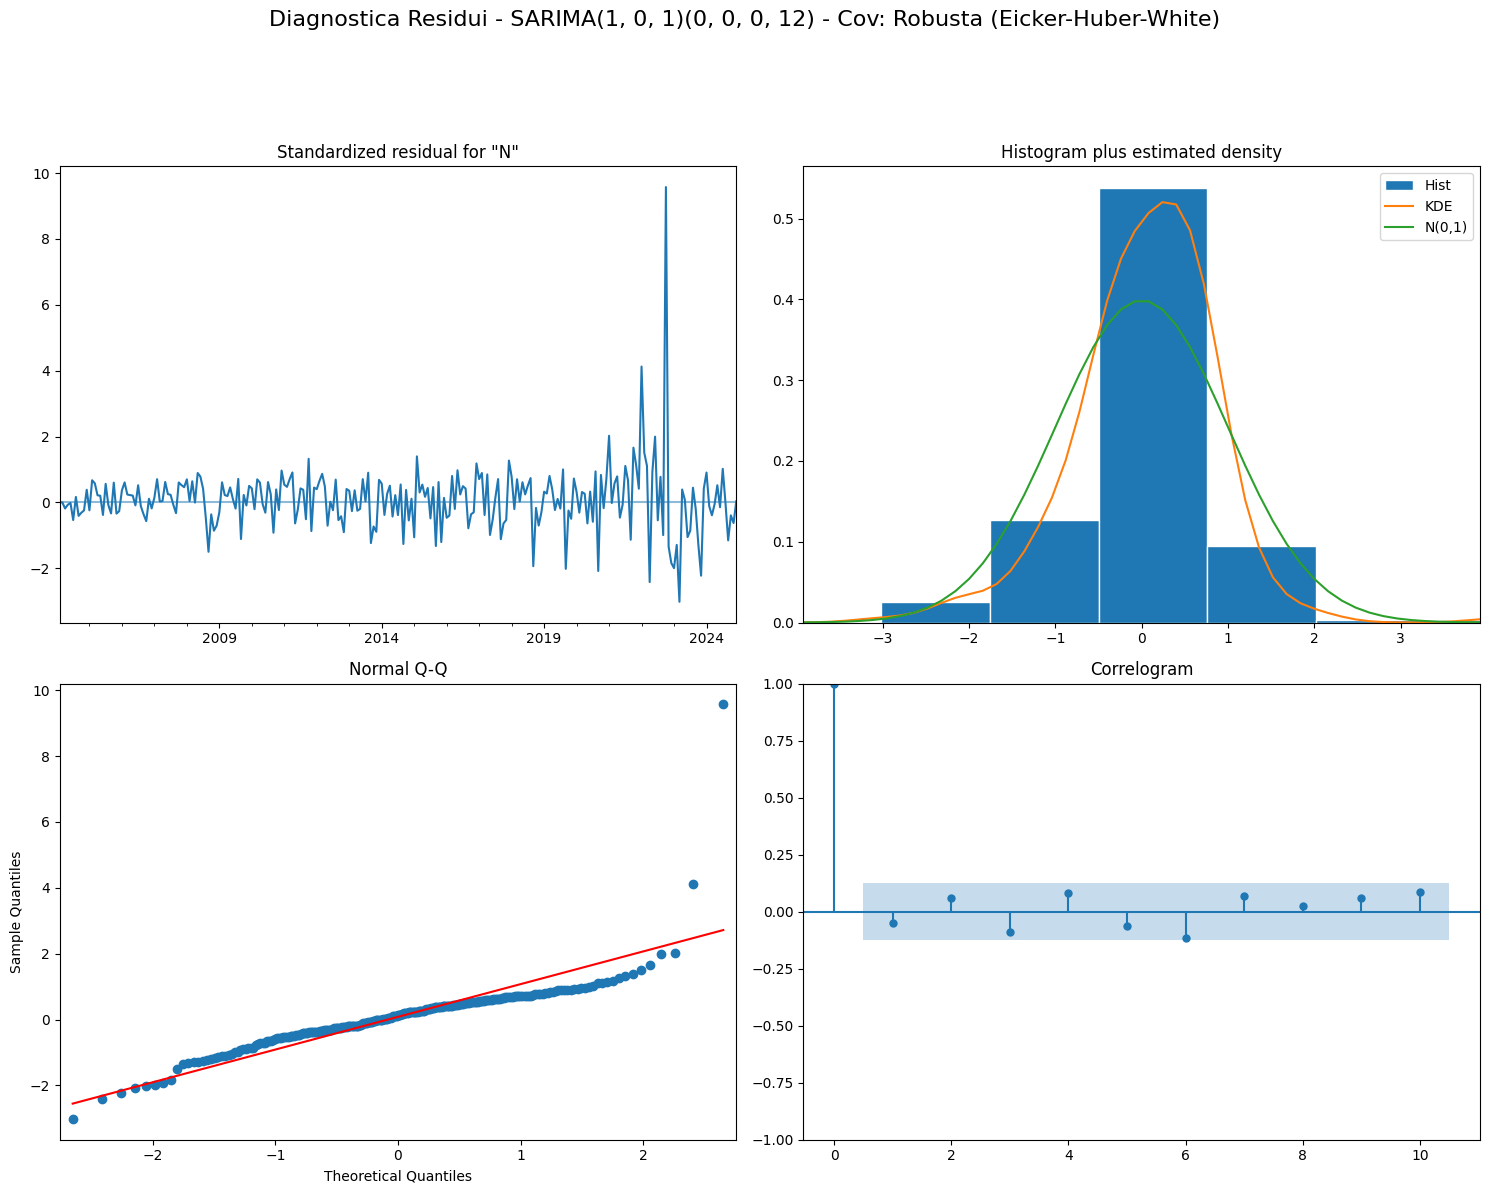


--- Test Statistici sui Residui ---
Test di Ljung-Box (lag=10): p-value = 0.1838 (H0: no autocorrelazione)
  -> OK: Residui probabilmente non autocorrelati.
Test di Jarque-Bera (normalità): p-value = 0.0000 (H0: normalità)
  -> ATTENZIONE: Residui potrebbero non essere normali.
--- Fine Diagnostica ---
Miglior modello SARIMAX (Cov: Robusta (Eicker-Huber-White)) salvato.

>>> SCRIPT MODELLO BASE (ARIMAX_base.ipynb) COMPLETATO <<<


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import itertools
import warnings
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
import pickle

# Ignoro i warning di convergenza e altri, come da tua preferenza
warnings.filterwarnings("ignore", category=sm.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# --- CONFIGURAZIONE GENERALE ---
PATH_INPUT_DIR_FASE2 = "/Users/tommaso/Desktop/tesi-inflation-gt/First_Difference_indexes/dati_preparati_fase2"
FILE_SERIE_STAZIONARIE_IN = os.path.join(PATH_INPUT_DIR_FASE2, "indici_gt_nic_stazionari_fase2.csv")
PATH_OUTPUT_MODELLI = "/Users/tommaso/Desktop/tesi-inflation-gt/SARIMAX_modelli"
PATH_OUTPUT_MODELLO_BASE = os.path.join(PATH_OUTPUT_MODELLI, "modello_base_hac_v5_corretto") 

FILE_GRAFICO_ACFPACF_INFL = os.path.join(PATH_OUTPUT_MODELLO_BASE, "acf_pacf_inflazione_staz_hac1.png")
FILE_RISULTATI_GRID_SEARCH = os.path.join(PATH_OUTPUT_MODELLO_BASE, "grid_search_sarimax_results_hac1.csv")
FILE_GRAFICO_DIAGNOSTICA_BEST = os.path.join(PATH_OUTPUT_MODELLO_BASE, "diagnostica_miglior_modello_final.png") 
FILE_MODELLO_PICKLE = os.path.join(PATH_OUTPUT_MODELLO_BASE, "miglior_modello_sarimax_final.pkl")

COL_INFLAZIONE_STAZ = 'NIC_destag_ISTAT_diff1'
BREAKPOINT_DATE_DUMMY = '2022-03-01'
MAX_LAGS_ACF_PACF = 36
SEASONAL_PERIOD = 12
MAX_P_NON_STAG, MAX_Q_NON_STAG = 2, 2
MAX_P_STAG, MAX_Q_STAG = 1, 1
ORDER_d_NON_STAG, ORDER_D_STAG = 0, 0
CRITERION_SELEZIONE = 'aic'

# --- FUNZIONI AUSILIARIE (invariate rispetto alla tua ultima versione) ---
def carica_dati_stazionari(path_file):
    print(f"--- Caricamento Serie Stazionarie da: {path_file} ---")
    try:
        df = pd.read_csv(path_file, index_col=0)
        df.index = pd.to_datetime(df.index)
        print(f"Serie caricate con successo. Shape: {df.shape}")
        return df
    except Exception as e: print(f"ERRORE caricamento: {e}"); return None

def crea_dummy_intervento(serie_index, breakpoint_date_str, dummy_name="dummy_intervento_mar2022"):
    breakpoint_ts = pd.Timestamp(breakpoint_date_str)
    dummy = pd.Series(0, index=serie_index, name=dummy_name)
    dummy[serie_index >= breakpoint_ts] = 1
    return dummy

def auto_sarima_grid_search(y_series, exog_series=None,
                           max_p=2, max_q=2, max_P=1, max_Q=1,
                           d=0, D=0, s=12,
                           criterion='aic', verbose=True):
    print(f"\n=== INIZIO RICERCA AUTOMATICA ORDINI SARIMA (Criterio: {criterion.upper()}) ===")
    # Assicuro che la funzione restituisca valid_results_df invece di all_search_results
    # se si vuole usare questo per il logging dei soli modelli validi.
    # Per ora, mantengo la restituzione di results_df (tutti i tentativi) per completezza.
    print(f"Range ordini: p<={max_p}, q<={max_q}, P<={max_P}, Q<={max_Q} | d={d}, D={D}, s={s}")
    p_rng, q_rng, P_rng, Q_rng = range(max_p+1), range(max_q+1), range(max_P+1), range(max_Q+1)
    all_orders_combinations = list(itertools.product(p_rng, q_rng, P_rng, Q_rng))
    print(f"Numero totale di combinazioni da testare: {len(all_orders_combinations)}")
    results_list = []
    for i, (p_val, q_val, P_val, Q_val) in enumerate(all_orders_combinations):
        current_order = (p_val, d, q_val); current_seasonal_order = (P_val, D, Q_val, s)
        if verbose and (i % 10 == 0 or i == len(all_orders_combinations) - 1):
            print(f"Sto testando il modello {i+1}/{len(all_orders_combinations)}: SARIMA{current_order}{current_seasonal_order}...")
        try:
            model = sm.tsa.SARIMAX(y_series, exog=exog_series, order=current_order, seasonal_order=current_seasonal_order,
                                 enforce_stationarity=False, enforce_invertibility=False,
                                 initialization='approximate_diffuse')
            fitted_model = model.fit(disp=False, maxiter=200, method='lbfgs')
            current_criterion_val = getattr(fitted_model, criterion.lower())
            lb_lags_to_test = min(10, len(y_series)//5) if len(y_series)//5 > 0 else 1
            lb_pvalue = np.nan
            if lb_lags_to_test > 0:
                 lb_df = acorr_ljungbox(fitted_model.resid, lags=[lb_lags_to_test], return_df=True)
                 lb_pvalue = lb_df['lb_pvalue'].iloc[0] if not lb_df.empty and 'lb_pvalue' in lb_df.columns else np.nan
            results_list.append({'order': current_order, 'seasonal_order': current_seasonal_order,
                               'AIC': fitted_model.aic, 'BIC': fitted_model.bic,
                               'LogLikelihood': fitted_model.llf, 'LjungBox_pvalue': lb_pvalue,
                               'Converged': fitted_model.mle_retvals.get('converged', False)})
        except Exception as e:
            results_list.append({'order': current_order, 'seasonal_order': current_seasonal_order,
                               'AIC': np.nan, 'BIC': np.nan, 'LogLikelihood': np.nan,
                               'LjungBox_pvalue': np.nan, 'Converged': False, 'Error': str(e)[:50]})
    results_df = pd.DataFrame(results_list)
    valid_results_df = results_df[results_df['Converged'] == True].copy()
    if valid_results_df.empty:
        print("ERRORE: Nessun modello SARIMAX è convergito durante la grid search.")
        return None, None, float('inf'), results_df
    print(f"\n{len(valid_results_df)} modelli sono convergiti con successo su {len(results_df)} testati.")
    valid_results_df = valid_results_df.sort_values(by=[criterion.upper(), 'LjungBox_pvalue'], ascending=[True, False])
    best_model_row = valid_results_df.iloc[0]
    final_best_order = best_model_row['order']
    final_best_seasonal_order = best_model_row['seasonal_order']
    final_best_criterion_val = best_model_row[criterion.upper()]
    print(f"\n=== MIGLIOR MODELLO TROVATO (secondo {criterion.upper()} e Ljung-Box) ===")
    print(f"Ordini: SARIMA{final_best_order}{final_best_seasonal_order}")
    print(f"{criterion.upper()}: {final_best_criterion_val:.3f}, BIC: {best_model_row['BIC']:.3f}, LogLik: {best_model_row['LogLikelihood']:.3f}")
    print(f"Ljung-Box p-value (residui): {best_model_row['LjungBox_pvalue']:.3f}")
    if best_model_row['LjungBox_pvalue'] > 0.05 : print("  -> OK: Residui sembrano non autocorrelati.")
    else: print("  -> ATTENZIONE: Residui potrebbero essere autocorrelati.")
    print("=== FINE RICERCA AUTOMATICA ORDINI SARIMA ===\n")
    return final_best_order, final_best_seasonal_order, final_best_criterion_val, results_df # Restituisco tutti i risultati

def plot_model_diagnostics_final(fitted_model_results, model_name="Modello", path_output_grafici=None, save_filename="diagnostica_modello.png"):
    print(f"\n--- Diagnostica Grafica e Test Residui per: {model_name} ---")
    residuals = fitted_model_results.resid
    try:
        fig = fitted_model_results.plot_diagnostics(figsize=(15, 12))
        fig.suptitle(f"Diagnostica Residui - {model_name}", fontsize=16, y=1.02)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        if path_output_grafici:
            if not os.path.exists(path_output_grafici): os.makedirs(path_output_grafici)
            full_save_path = os.path.join(path_output_grafici, save_filename)
            plt.savefig(full_save_path); print(f"Grafico diagnostica salvato in: {full_save_path}")
        plt.show()
    except Exception as e:
        print(f"ERRORE durante fitted_model.plot_diagnostics(): {e}. Tentativo con plot manuali.")
        # ... (codice per plot manuali se necessario, come nella tua versione precedente) ...

    print("\n--- Test Statistici sui Residui ---")
    lb_lags_diag = min(10, len(residuals)//5) if len(residuals)//5 > 0 else 1
    if lb_lags_diag > 0:
        lb_df_diag = acorr_ljungbox(residuals, lags=[lb_lags_diag], return_df=True)
        lb_pvalue_diag = lb_df_diag['lb_pvalue'].iloc[0] if not lb_df_diag.empty else np.nan
        print(f"Test di Ljung-Box (lag={lb_lags_diag}): p-value = {lb_pvalue_diag:.4f} (H0: no autocorrelazione)")
        if lb_pvalue_diag > 0.05: print("  -> OK: Residui probabilmente non autocorrelati.")
        else: print("  -> ATTENZIONE: Residui potrebbero essere autocorrelati.")
    else: print("Test Ljung-Box non eseguito (serie residui troppo corta).")
    if len(residuals) > 2:
        jb_stat, jb_pvalue = jarque_bera(residuals)
        print(f"Test di Jarque-Bera (normalità): p-value = {jb_pvalue:.4f} (H0: normalità)")
        if jb_pvalue > 0.05: print("  -> OK: Residui probabilmente normali.")
        else: print("  -> ATTENZIONE: Residui potrebbero non essere normali.")
    else: print("Test Jarque-Bera non eseguito (serie residui troppo corta).")
    print("--- Fine Diagnostica ---")

# --- ESECUZIONE SCRIPT (ARIMAX_base.ipynb) ---
if __name__ == "__main__":
    print(">>> INIZIO SCRIPT: Costruzione Modello Base SARIMAX con Errori Standard Robusti <<<\n")
    os.makedirs(PATH_OUTPUT_MODELLO_BASE, exist_ok=True)
    print(f"I risultati di questo script verranno salvati in: '{PATH_OUTPUT_MODELLO_BASE}'\n")

    df_serie_stazionarie = carica_dati_stazionari(FILE_SERIE_STAZIONARIE_IN)
    if df_serie_stazionarie is None or COL_INFLAZIONE_STAZ not in df_serie_stazionarie.columns:
        print(f"ERRORE CRITICO: Dati non caricati o colonna '{COL_INFLAZIONE_STAZ}' mancante."); exit()

    y_inflazione = df_serie_stazionarie[COL_INFLAZIONE_STAZ].dropna()
    if y_inflazione.empty: print(f"ERRORE: Serie inflazione '{COL_INFLAZIONE_STAZ}' vuota."); exit()

    dummy_mar2022 = crea_dummy_intervento(y_inflazione.index, BREAKPOINT_DATE_DUMMY)
    dummy_mar2022_aligned = dummy_mar2022.reindex(y_inflazione.index, fill_value=0).astype(float)

    print(f"--- Analisi ACF/PACF per: {COL_INFLAZIONE_STAZ} (guida visuale) ---")
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(y_inflazione, lags=MAX_LAGS_ACF_PACF, ax=axes[0], title=f"ACF - {COL_INFLAZIONE_STAZ}")
    axes[0].grid(True, alpha=0.5)
    plot_pacf(y_inflazione, lags=MAX_LAGS_ACF_PACF, ax=axes[1], title=f"PACF - {COL_INFLAZIONE_STAZ}", method='ols')
    axes[1].grid(True, alpha=0.5)
    plt.tight_layout(); plt.savefig(FILE_GRAFICO_ACFPACF_INFL); plt.show()

    best_order, best_seasonal_order, _, all_search_results_df = auto_sarima_grid_search(
        y_inflazione, exog_series=dummy_mar2022_aligned,
        max_p=MAX_P_NON_STAG, max_q=MAX_Q_NON_STAG, max_P=MAX_P_STAG, max_Q=MAX_Q_STAG,
        d=ORDER_d_NON_STAG, D=ORDER_D_STAG, s=SEASONAL_PERIOD, criterion=CRITERION_SELEZIONE)

    if all_search_results_df is not None:
        all_search_results_df.to_csv(FILE_RISULTATI_GRID_SEARCH, index=False)
        print(f"Risultati grid search salvati in: {FILE_RISULTATI_GRID_SEARCH}")

    if best_order and best_seasonal_order:
        model_label_base = f"SARIMA{best_order}{best_seasonal_order}"
        print(f"\n--- Stima Finale e Diagnostica del Miglior Modello: {model_label_base} ---")
        
        # Definisco il modello con gli ordini migliori
        miglior_modello_def = sm.tsa.SARIMAX(y_inflazione,
                                           exog=dummy_mar2022_aligned,
                                           order=best_order,
                                           seasonal_order=best_seasonal_order,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False,
                                           initialization='approximate_diffuse')
        
        risultati_miglior_modello = None
        tipo_covarianza_usata = "Non Robusta (Default)"

        # Tento la stima con Errori Standard HAC (Newey-West)
        # Ometto 'maxlags' da cov_kwds per usare il default di statsmodels, che è spesso più robusto.
        # Il default è solitamente int(np.floor(4*(nobs/100.)**(2/9.)))
        # Se vuoi specificarlo, puoi aggiungere: 'maxlags': int(np.floor(4*(len(y_inflazione)/100)**(2/9)))
        print(f"Sto tentando la stima del modello con errori standard HAC (Newey-West)...")
        try:
            risultati_miglior_modello = miglior_modello_def.fit(
                disp=False, maxiter=250, # Aumento leggermente maxiter
                cov_type='HAC',
                cov_kwds={
                    'kernel': 'bartlett',       # Kernel comune per Newey-West
                    'use_correction': True,    # Applica correzione per campioni finiti
                    # 'maxlags': None          # Lascio che statsmodels scelga il default per maxlags
                                               # oppure imposto un valore es. int(len(y_inflazione)**0.25)
                }
            )
            tipo_covarianza_usata = "HAC (Newey-West)"
            print("Stima con errori HAC completata con successo.")
        except Exception as e_hac:
            print(f"ERRORE durante la stima con errori HAC: {e_hac}")
            print("Tento la stima con errori standard robusti semplici (HC0)...")
            try:
                risultati_miglior_modello = miglior_modello_def.fit(
                    disp=False, maxiter=250,
                    cov_type='robust' # Eicker-Huber-White, robusto a eteroschedasticità
                )
                tipo_covarianza_usata = "Robusta (Eicker-Huber-White)"
                print("Stima con errori 'robust' completata con successo.")
            except Exception as e_robust:
                print(f"ERRORE durante la stima con errori 'robust': {e_robust}")
                print("Tento la stima con errori standard non robusti (default)...")
                try:
                    risultati_miglior_modello = miglior_modello_def.fit(disp=False, maxiter=250)
                    tipo_covarianza_usata = "Non Robusta (Default OIM/OPG)"
                    print("Stima con errori standard default completata con successo.")
                    print("ATTENZIONE: L'inferenza potrebbe essere meno affidabile a causa di potenziale eteroschedasticità non corretta.")
                except Exception as e_default:
                    print(f"ERRORE CRITICO: Impossibile stimare il modello anche con errori standard default: {e_default}")
                    risultati_miglior_modello = None
        
        # Procedo con diagnostica e salvataggio solo se la stima ha avuto successo
        if risultati_miglior_modello:
            model_final_name = f"{model_label_base} - Cov: {tipo_covarianza_usata}"
            print(f"\n--- Sommario Miglior Modello SARIMAX ({tipo_covarianza_usata}) ---")
            print(risultati_miglior_modello.summary())

            plot_model_diagnostics_final(risultati_miglior_modello,
                                   model_name=model_final_name,
                                   path_output_grafici=PATH_OUTPUT_MODELLO_BASE,
                                   save_filename=f"diagnostica_{tipo_covarianza_usata.split(' ')[0].lower()}.png")
            
            with open(FILE_MODELLO_PICKLE.replace(".pkl", f"_{tipo_covarianza_usata.split(' ')[0].lower()}.pkl"), 'wb') as pkl_file:
                pickle.dump(risultati_miglior_modello, pkl_file)
            print(f"Miglior modello SARIMAX (Cov: {tipo_covarianza_usata}) salvato.")
        else:
            print("La stima del modello finale è fallita con tutti i tipi di covarianza tentati.")

    else:
        print("\nNessun modello ottimale trovato dalla grid search. Impossibile procedere con la stima finale.")

    print("\n>>> SCRIPT MODELLO BASE (ARIMAX_base.ipynb) COMPLETATO <<<")
